## Basic Case

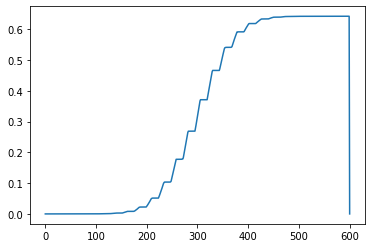

In [1]:
# 1. Load configuration file
import json
with open('../data_files/config_1hrad.json') as f:
     config = json.load(f)

import sys
sys.path.append('../')

# 2. Import SIMOC
from agent_model import AgentModel

# 3. Initialize model
model = AgentModel.from_config(config, data_collection=True)

# 4. Step the model forward
model.step_to(n_steps=601)

# 5. Get data from model
data = model.get_data(debug=True)

# 6. Inspect data
import matplotlib.pyplot as plt
radish_growth = data['radish']['growth']['growth_rate']
plt.plot([i for i in range(len(radish_growth))], radish_growth)

## Custom Agent

Define an example agent, mushrooms.
- Consumes 10g o2 and 10g inedible_biomass per hour (sigmoid)
- Grow 20g per hour (normal)
- Lifetime of 30 days
- At end of lifetime, 90% edible (mushroom) 10% waste (mushroom_SMS)

In [2]:
# I specify 2 new currencies:
currency_desc = {
    'food': {
        # The edible product of the mushroom plant
        'mushroom': {
            'label': 'Mushroom'
            # Here I could also specify nutrition data
        }
    },
    'nutrients': {
        # The inedible portion of the mushroom. This is a separate 
        # currency from inedible_biomass, because mushrooms *consume*
        # inedible_biomass.
        'mushroom_sms': {
            'label': 'Spent Mushroom Substrate'
        }
    }
}

agent_desc = {
    # Add a capacity to store these currencies in the appropriate agent
    'storage': {
        'food_storage': {
            'data': {
                'characteristics': [
                    {
                        'type': 'capacity_mushroom',
                        'value': 1000,
                        'unit': 'kg'
                    }
                ]
            }
        },
        'nutrient_storage': {
            'data': {
                'characteristics': [
                    {
                        'type': 'capacity_mushroom_sms',
                        'value': 1000,
                        'unit': 'kg'
                    }
                ]
            }
        }
    },
    # Agents under 'plants' have lifecycle, growth & reproduction
    'plants': {
        'mushroom': {
            'data': {
                'input': [
                    {
                        # Matches a currency
                        'type': 'o2',
                        # Average value over life of plant
                        'value': 0.000225,
                        # If amount in storage is less than demand at any step:
                        # - if required == 'desired', increment deprive (see below),
                        #   don't increment age, but process other currencies as normal
                        # - if required == 'mandatory', exit step function with no side-effects
                        # - if not required, ignore and continue as normal
                        'required': 'desired',
                        'flow_rate': {
                            'unit': 'kg',
                            'time': 'hour'
                        },
                        'growth': {
                            'lifetime': {
                                'type': 'sigmoid',
                                'steepness': 0.2    # Value is 'reshaped' over lifetime
                            }
                        },
                        # If demand is unfulfilled for longer than this, agent dies.
                        'deprive':  {
                            'value': 72,
                            'unit': 'hour'
                        }
                    },
                    {
                        'type': 'inedible_biomass',
                        'value': 0.01,
                        'required': 'desired',
                        'flow_rate': {
                            'unit': 'kg',
                            'time': 'hour',
                        },
                        'growth': {
                            'lifetime': {
                                'type': 'sigmoid'
                            }
                        },
                        'deprive': {
                            'value': 72,
                            'unit': 'hour'
                        }
                    },
                ],
                'output': [
                    {
                        # Plants 'store' their accumulated biomass internally. See 
                        # the 'capacity_biomass' characteristic, and the connection
                        # {from: self.biomass, to: self.biomass}.
                        'type': 'biomass',
                        'value': 0.02,
                        'flow_rate': {
                            'unit': 'kg',
                            'time': 'hour'
                        },
                        'growth': {
                            'lifetime': {
                                'type': 'norm'
                            }
                        }
                    },
                    {                        
                        'type': 'co2',
                        'value': 0.000131,
                        'flow_rate': {
                            'unit': 'kg',
                            'time': 'hour'
                        },
                        'growth': {
                            'lifetime': {
                                'type': 'sigmoid',
                                'steepness': 0.2    # Value is 'reshaped' over lifetime
                            }
                        }
                    },
                    {
                        'type': 'mushroom',
                        'value': 0.9,
                        'weighted': ['biomass'],
                        'flow_rate': {
                            'unit': 'kg',
                            'time': 'hour'
                        },
                        'criteria': {
                            'name': 'grown',
                            'limit': '=',
                            'value': True
                        }
                    },
                    {
                        'type': 'mushroom_sms',
                        'value': 0.1,
                        'weighted': ['biomass'],
                        'flow_rate': {
                            'unit': 'kg',
                            'time': 'hour'
                        },
                        'criteria': {
                            'name': 'grown',
                            'limit': '=',
                            'value': True
                        }
                    }
                ],
                'characteristics': [
                    {
                        'type': 'lifetime',
                        'value': 336,
                        'unit': 'hour'
                    },
                    {
                        'type': 'growth_criteria',
                        'value': 'out_biomass'
                    },
                    {
                        'type': 'capacity_biomass',
                        'value': 100,
                        'unit': 'kg'
                    },
                    {
                        'type': 'reproduce',
                        'value': True
                    }
                ]
            }
        }
    }
}

agent_conn = [
    # Specify where to get/put currencies.
    # Note that 'greenhouse' and 'habitat' are special connections
    # which will be updated at initialization to match the selected
    # habitat and greenhouse agents (e.g. 'crew_habitat_small')
    {
        'from': 'greenhouse.o2',
        'to': 'mushroom.o2'
    },
    {
        'from': 'mushroom.co2',
        'to': 'greenhouse.co2'
    },
    {
        'from': 'nutrient_storage.inedible_biomass',
        'to': 'mushroom.inedible_biomass'
    },
    {
        'from': 'mushroom.biomass',
        'to': 'mushroom.biomass'
    },
    {
        'from': 'mushroom.mushroom',
        'to': 'food_storage.mushroom',
    },
    {
        'from': 'mushroom.mushroom_sms',
        'to': 'nutrient_storage.mushroom_sms'
    }
]

In [3]:
import json
with open('../data_files/config_1hrad.json') as f:
    config = json.load(f)
    
# Add 10 square meters of mushrooms to the simulation, More convient to measure in kg of IEB
config['agents']['mushroom'] = {'amount': 1}
# Start with 200 kg of inedible_biomass in storage
config['agents']['nutrient_storage']['inedible_biomass'] = 200

from agent_model import AgentModel
model = AgentModel.from_config(config,
                               data_collection=True,
                               currency_desc=currency_desc,
                               agent_desc=agent_desc,
                               agent_conn=agent_conn)
model.step_to(n_steps=600)  # One past the agent's lifetime
data = model.get_data(debug=True)

## Inspect a group
Plot all elements for one group with an agent.

Available groups vary by agent based on function, and may include: growth, storage, flows, deprive

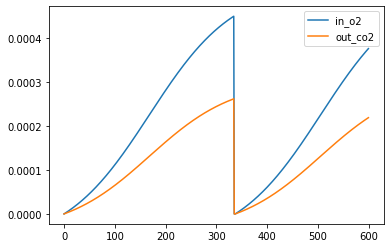

In [5]:
from agent_model.util import plot_agent

plot_agent(data, 'mushroom', 'flows', exclude=['biomass','inedible_biomass','mushroom','mushroom_sms'])
# plot_group(data['mushroom']['flows'], j=719)
# plot_group(data['mushroom']['growth'], exclude=['agent_step_num'])
# print(data.keys())
# print(data['mushroom'].keys())

## Inspect a Currency
Plot all flows of a particular currency

0.00013082511671756435


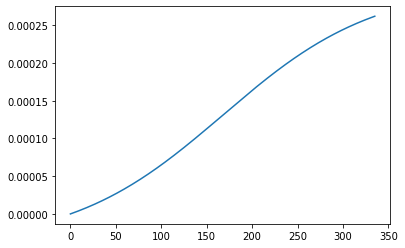

In [6]:
mushroom=model.get_agents_by_type('mushroom')[0]
print(sum(mushroom.step_values['out_co2'])/len(mushroom.step_values['out_co2']))
plt.plot(mushroom.step_values['out_co2'])

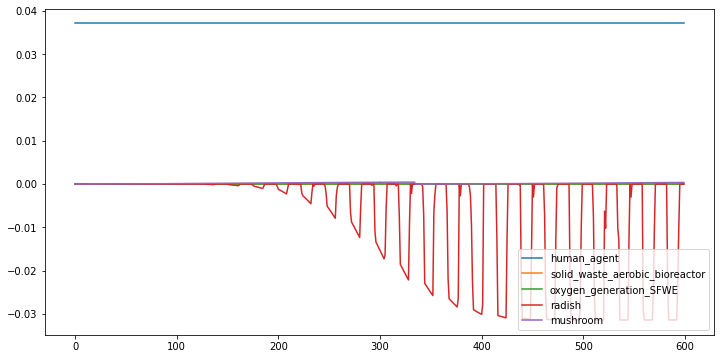

In [9]:
from agent_model.util import parse_data
import matplotlib.pyplot as plt

data = model.get_data(debug=True)
def plot_currency(data, currency, exclude=[], i=None, j=None):
    """Plot all agents who use a particular currency"""
    flows = {}
    path = ['*', 'flows', '*', currency, 'SUM']
    all_flows = parse_data(data, path)
    for agent, record in all_flows.items():
        for direction in {'in', 'out'}:
            if direction not in record:
                continue
            values = record[direction]
            if direction == 'out':
                values = [-v for v in values] 
            flows[agent] = values

    
    # Plot data
    plt.figure(figsize=(12,6))
    i = i if i else 0
    length = len(next(iter(flows.values())))
    j = j if j else length
    steps = [x for x in range(j-i)]
    for agent_name, agent_data in flows.items():
        if agent_name in exclude:
            continue
        pad_zeros = len(steps) - len(agent_data)
        if pad_zeros > 0:
            agent_data += [0] * pad_zeros
        plt.plot(steps, agent_data[i:j], label=agent_name)
    plt.legend(loc='lower right')
    plt.show()
            
plot_currency(data, 'o2')
# plot_currency(data, 'potable', exclude=['multifiltration_purifier_post_treatment'])